Part 1:
Dataset used: https://www.tensorflow.org/datasets/catalog/fashion_mnist

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [20]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

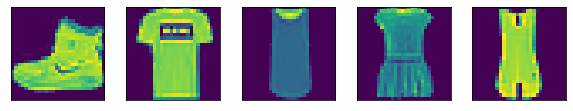

In [21]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i])
plt.show()

In [22]:
train_images = np.expand_dims(train_images, axis=-1)
train_images = train_images.astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)

test_images = np.expand_dims(test_images, axis=-1)
test_images = test_images.astype('float32') / 255
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)


In [23]:
model = tf.keras.models.Sequential([  
    tf.keras.layers.Conv2D(28, (3,3), activation='relu', input_shape=(28, 28, 1)),  
    tf.keras.layers.MaxPooling2D((2, 2)),  
    tf.keras.layers.Conv2D(56, (3,3), activation='relu'),  
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dense(10, activation='softmax'),  
])  

In [25]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 30s 15ms/step - loss: 0.8530 - accuracy: 0.6764
Epoch 2/3
1875/1875 [==============================] - 36s 19ms/step - loss: 0.5670 - accuracy: 0.7862
Epoch 3/3
1875/1875 [==============================] - 36s 19ms/step - loss: 0.4954 - accuracy: 0.8186


In [26]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 2s - loss: 0.5171 - accuracy: 0.8115


In [27]:
print(test_acc)

0.8115000128746033


My pattern of layers was two Conv and Maxpooling layers each, alternating between one type and the other.  I chose this pattern because I looked online at how many layers are recommended and found about 2 to 3 is a good range, as using any more can cause the accuracy gain to diminish.  The metric I used was accuracy on the test_images dataset, and the results I got from this inital training task was approximately 81.15%.  

Part 2:

In [28]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

In [29]:
vgg16 = VGG16(include_top=False, weights=None, input_shape=(32, 32, 1))

for layer in vgg16.layers:
    layer.trainable = False

model = tf.keras.models.Sequential([  
    vgg16,
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dense(10, activation='sigmoid'),  
])

In [30]:
train_images2 = tf.image.resize(train_images, (32, 32))
test_images2 = tf.image.resize(test_images, (32, 32))

print(train_images2.shape, test_images2.shape)

(60000, 32, 32, 1) (10000, 32, 32, 1)


In [31]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.fit(train_images2, train_labels, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 207s 110ms/step - loss: 2.3028 - accuracy: 0.0990
Epoch 2/3
1875/1875 [==============================] - 204s 109ms/step - loss: 2.3028 - accuracy: 0.0992
Epoch 3/3
1875/1875 [==============================] - 205s 110ms/step - loss: 2.3028 - accuracy: 0.0975


In [34]:
test_loss, test_acc = model.evaluate(test_images2,  test_labels, verbose=2)

313/313 - 34s - loss: 2.3026 - accuracy: 0.1000


In [35]:
print(test_acc)

0.10000000149011612


The final evaluation when doing this training was that a ton of accuracy was lost with the final result being 10% accuracy.  This is very likely because I had to resize my image datatset from 28x28 to 32x32, which could throw off the image comparison when testing.  I tried resizing the test image dataset as well to make sure I was comparing similar sized images, but this did not help the final accuracy.

Part 3:

In [48]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

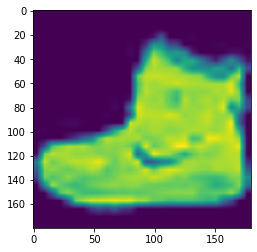

In [49]:
image = train_images[0]
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [50]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [51]:
image = tf.expand_dims(image, 0)

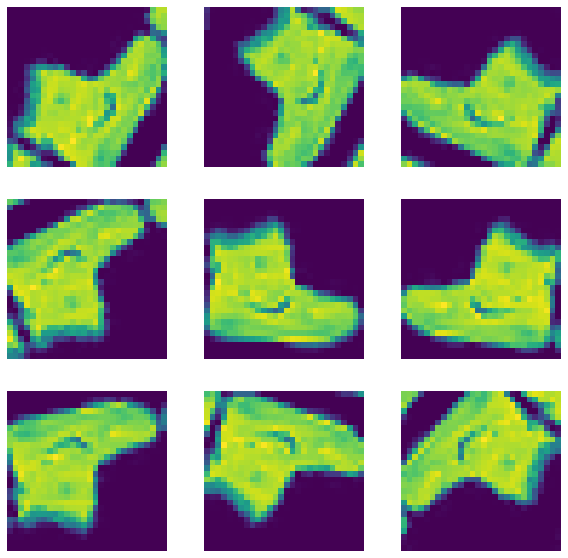

In [52]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [53]:
model = tf.keras.models.Sequential([  
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dense(10, activation='softmax'),  
])

In [54]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
print(train_images.shape)
print(train_labels.shape)
history = model.fit(train_images, train_labels, epochs=3)

(60000, 28, 28, 1)
(60000, 10)
Epoch 1/3
1875/1875 [==============================] - 28s 14ms/step - loss: 1.8794 - accuracy: 0.3125
Epoch 2/3
1875/1875 [==============================] - 27s 14ms/step - loss: 1.5641 - accuracy: 0.4317
Epoch 3/3
1875/1875 [==============================] - 27s 14ms/step - loss: 1.4240 - accuracy: 0.4827


In [55]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 2s - loss: 1.2662 - accuracy: 0.5416


In [56]:
print(test_acc)

0.5415999889373779


I observed another drop in accuracy this time, but much less than with the second iteration.  The final accuracy was approximately 54.16% and is likely due to the applied transformations causing less certainty with what type of image classified as what article of clothing.  Also, the images after being augmented show pieces of the clothing being flipped to the other side of the image which splits up the image being used for training and causes a lot of conflicting results.